# 第4章

### コード4.1

In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import Image

import os, sys, re, datetime, time
from pathlib import Path

from matplotlib import pyplot as plt
import japanize_matplotlib
import seaborn as sns
plt.style.use("bmh")
import numpy as np
import pandas as pd
from scipy import stats

import dask.dataframe as dd

from tqdm import tqdm_notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pymc3 as pm

/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [11]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (16, 4)
plt.rcParams["font.family"] = "IPAexGothic"
import logging
logging.basicConfig(level=logging.INFO)

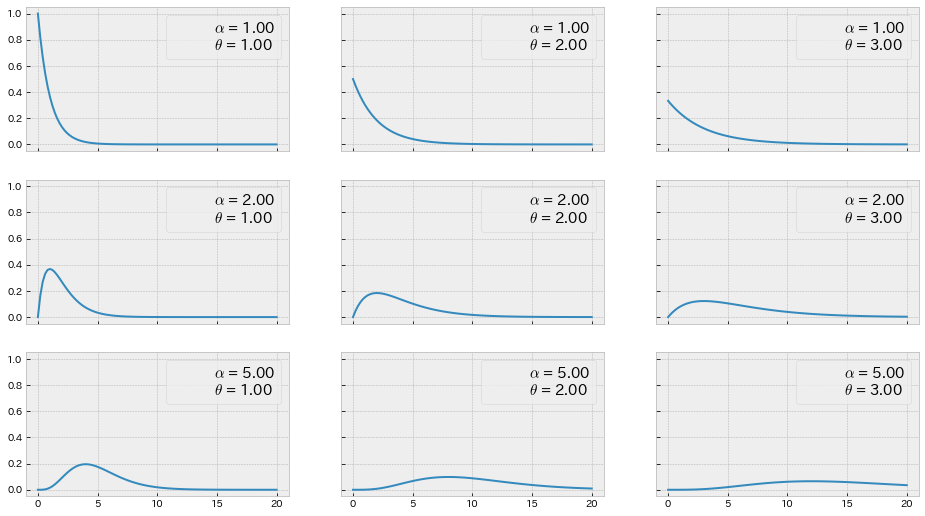

In [19]:
rates = [1, 2, 5]
scales = [1, 2, 3]

x = np.linspace(0, 20, 100)
fig = plt.figure(figsize=(16, 9))
axes = fig.subplots(len(rates), len(scales), sharex=True, sharey=True)
for _axes, rate in zip(axes, rates):
    for ax, scale in zip(_axes, scales):
        rv = stats.gamma(a=rate, scale=scale)
        ax.plot(x, rv.pdf(x))
        label = f'$\\alpha$ = {rate:3.2f}\n$\\theta$ = {scale:3.2f}'
        ax.plot(0, 0, label=label, alpha=0)
        ax.legend(fontsize=15)        

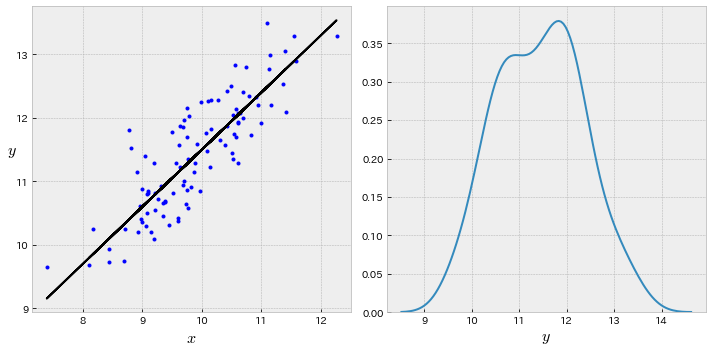

In [23]:
N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, .5, size=N)

x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real * x
y = y_real + eps_real

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(x, y, 'b.')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.plot(x, y_real, 'k')
plt.subplot(1,2,2)
sns.kdeplot(y)
plt.xlabel('$y$', fontsize=16)
plt.tight_layout()
plt.savefig('B04958_04_02.png', dpi=300, figsize=(5.5, 5.5))

In [30]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = pm.Deterministic('mu', alpha + beta * x)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(11000, step, start, njobs=1, chains=1)

logp = -72.924, ||grad|| = 0.00078836: 100%|██████████| 33/33 [00:00<00:00, 1646.78it/s]  
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [epsilon]
INFO:pymc3:>Metropolis: [epsilon]
>Metropolis: [beta]
INFO:pymc3:>Metropolis: [beta]
>Metropolis: [alpha]
INFO:pymc3:>Metropolis: [alpha]
100%|██████████| 11500/11500 [00:03<00:00, 3004.13it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks


In [31]:
trace = trace[1000:]

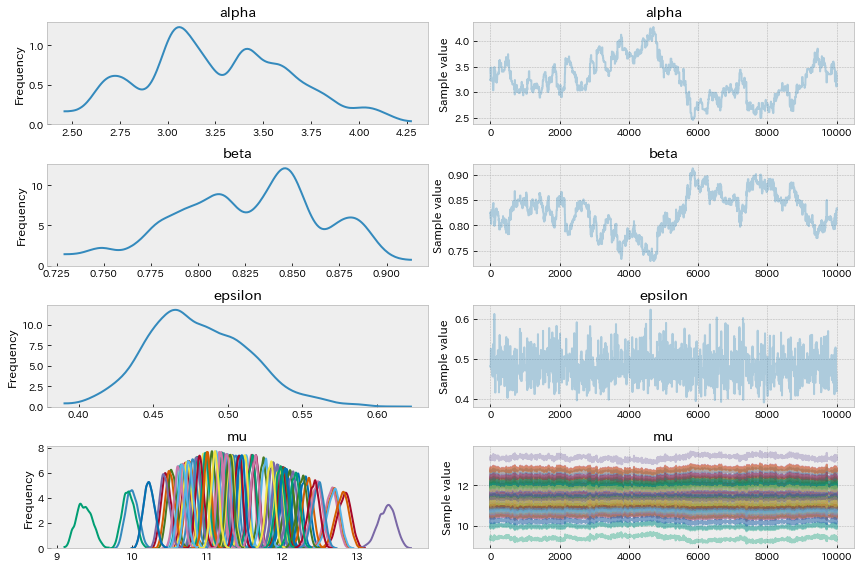

In [32]:
pm.traceplot(trace);

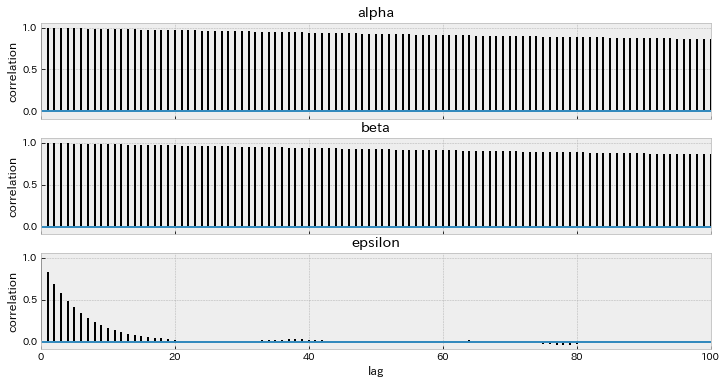

In [34]:
varnames = ['alpha', 'beta', 'epsilon']
pm.autocorrplot(trace, varnames);

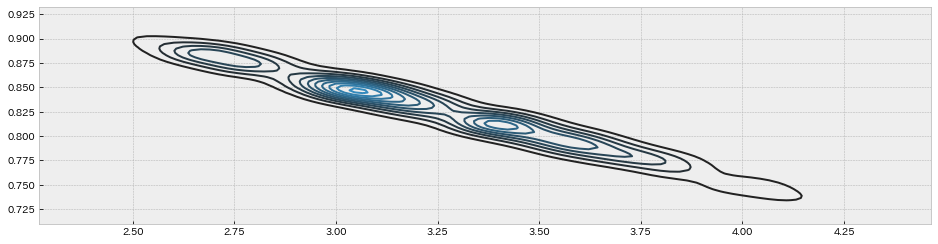

In [35]:
sns.kdeplot(trace['alpha'], trace['beta'])

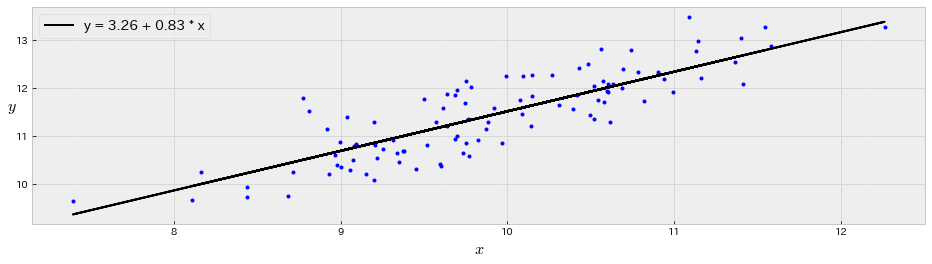

In [36]:
plt.plot(x, y, 'b.')

alpha_m = trace['alpha'].mean()
beta_m = trace['beta'].mean()
label = f'y = {alpha_m:.2f} + {beta_m:.2f} * x'
plt.plot(x, alpha_m + beta_m * x, c='k', label=label)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)

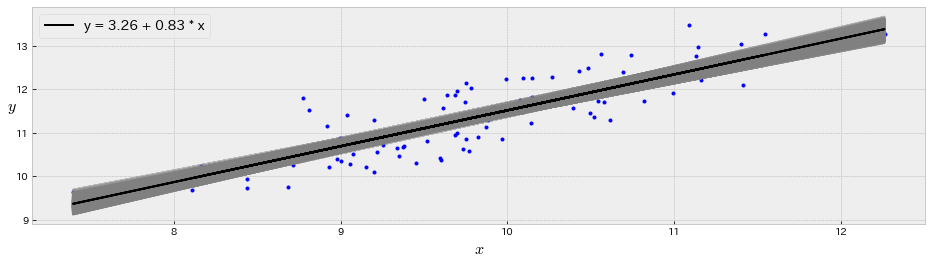

In [37]:
plt.plot(x, y, 'b.')

idx = range(0, len(trace[alpha]), 10)
plt.plot(x, trace['alpha'][idx] + trace['beta'][idx] * x[:, np.newaxis], c='gray', alpha=.5)

label = f'y = {alpha_m:.2f} + {beta_m:.2f} * x'
plt.plot(x, alpha_m + beta_m * x, c='k', label=label)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)

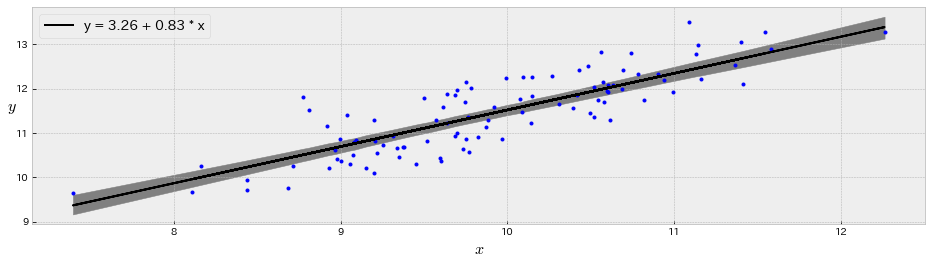

In [40]:
plt.plot(x, y, 'b.')
label = f'y = {alpha_m:.2f} + {beta_m:.2f} * x'
plt.plot(x, alpha_m + beta_m * x, c='k', label=label)

idx = np.argsort(x)
x_ord = x[idx]
sig = pm.hpd(trace['mu'], alpha=.02)[idx]
plt.fill_between(x_ord, sig[:, 0], sig[:, 1], color='gray')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)

100%|██████████| 1000/1000 [00:00<00:00, 1375.26it/s]


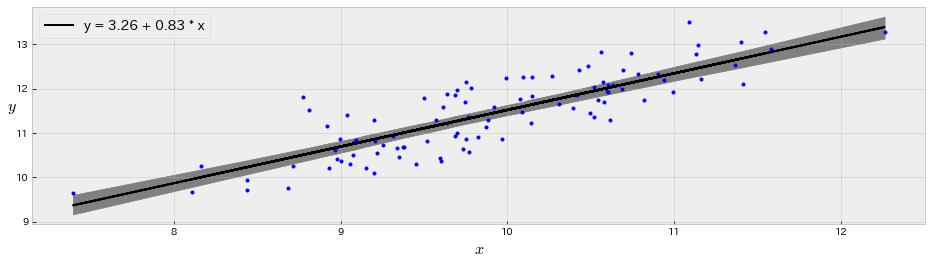

In [44]:
ppc = pm.sample_ppc(trace, samples=1000, model=model)
plt.plot(x, y, 'b.')
label = f'y = {alpha_m:.2f} + {beta_m:.2f} * x'
plt.plot(x, alpha_m + beta_m * x, c='k', label=label)

idx = np.argsort(x)
x_ord = x[idx]
sig0 = pm.hpd(ppc['y_pred'], alpha=.5)[idx]
sig1 = pm.hpd(ppc['y_pred'], alpha=.05)[idx]

plt.fill_between(x_ord, sig[:, 0], sig[:, 1], color='gray', alpha=1)
plt.fill_between(x_ord, sig[:, 0], sig[:, 1], color='gray', alpha=0.5)

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)

In [48]:
N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, .5, size=N)

x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real * x
y = y_real + eps_real

with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = alpha + beta * x
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    rb = pm.Deterministic('rb', (beta * x.std() / y.std()) ** 2)
    
    y_mean = y.mean()
    ss_reg = pm.math.sum((mu - y_mean) ** 2)
    ss_tot = pm.math.sum((y - y_mean) ** 2)
    rss = pm.Deterministic('rss', ss_reg / ss_tot)
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(11000, step, start, njobs=1, chains=1)

logp = -78.727, ||grad|| = 0.052371: 100%|██████████| 33/33 [00:00<00:00, 1907.18it/s]  
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [epsilon, beta, alpha]
INFO:pymc3:NUTS: [epsilon, beta, alpha]
100%|██████████| 11500/11500 [00:46<00:00, 245.53it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks


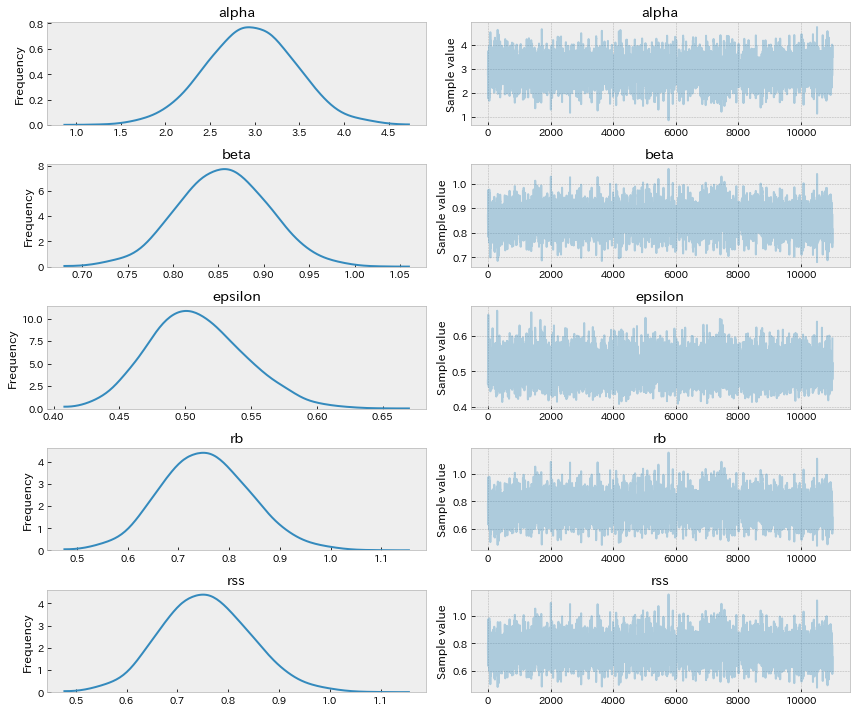

In [49]:
pm.traceplot(trace);

In [50]:
varnames = ['alpha', 'beta', 'epsilon', 'rb', 'rss']
pm.summary(trace, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,2.947951,0.500772,0.009719,1.934793,3.899653
beta,0.854472,0.050109,0.000975,0.756697,0.953539
epsilon,0.508573,0.036228,0.000476,0.443720,0.583149
rb,0.752570,0.088063,0.001713,0.581875,0.926793
rss,0.755154,0.088121,0.001715,0.591948,0.937630


Text(0,0.5,'$x_2$')

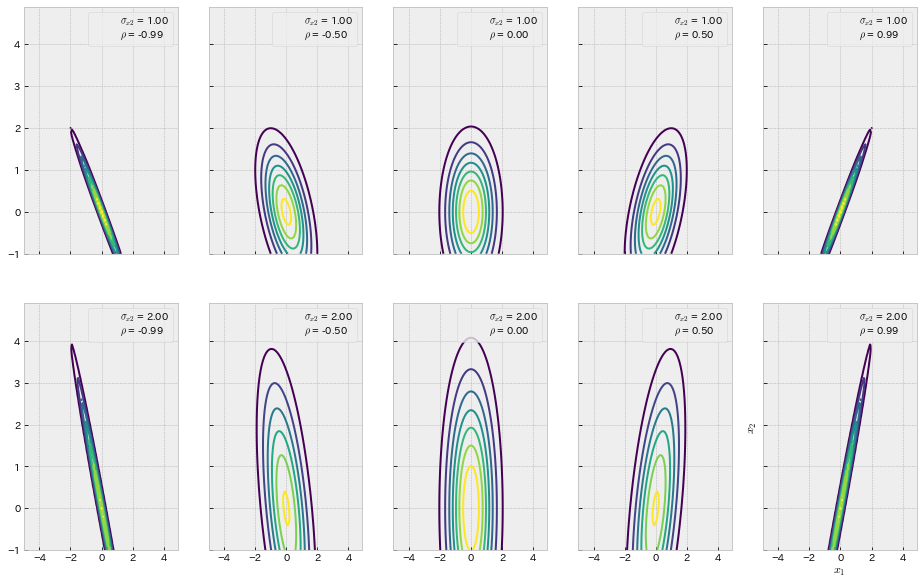

In [55]:
sigma_x1 = 1
sigmas_x2 = [1, 2]
rhos = [-0.99, -0.5, 0, 0.5, 0.99]

x, y = np.mgrid[-5:5:0.1, -1:5:0.1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x
pos[:, :, 1] = y

fig = plt.figure(figsize=(16, 10))
axes = fig.subplots(len(sigmas_x2), len(rhos), sharex=True, sharey=True)

for axes_, sigma_x2 in zip(axes, sigmas_x2):
    for ax, rho in zip(axes_, rhos):
        cov = [
            [sigma_x1 ** 2, sigma_x1 * sigma_x2 * rho],
            [sigma_x1 * sigma_x2 * rho, sigma_x2 ** 2]
        ]
        
        rv = stats.multivariate_normal([0, 0], cov)
        ax.contour(x, y, rv.pdf(pos))
        ax.plot(0, 0, label="$\\sigma_{{x2}}$ = {:3.2f}\n$\\rho$ = {:3.2f}".format(sigma_x2, rho), alpha=0)
        ax.legend()
                
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

In [62]:
N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, .5, size=N)

x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real * x
y = y_real + eps_real

data = np.stack((x, y)).T

with pm.Model() as model:
    mu = pm.Normal('mu', mu=data.mean(0), sd=10, shape=2)
    
    sigma_1 = pm.HalfNormal('sigma_1', 10)
    sigma_2 = pm.HalfNormal('sigma_2', 10)
    rho = pm.Uniform('rho', -1, 1)
    
    
    cov = pm.math.stack((
        [sigma_1**2, sigma_1*sigma_2*rho],
        [sigma_1*sigma_2*rho, sigma_2**2]
    ))
    
    y_pred = pm.MvNormal('y_pred', mu=mu, cov=cov, observed=data)
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(11000, step, start, njobs=1, chains=1)

logp = -234.3, ||grad|| = 78.963: 100%|██████████| 20/20 [00:00<00:00, 533.89it/s]  
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [rho, sigma_2, sigma_1, mu]
INFO:pymc3:NUTS: [rho, sigma_2, sigma_1, mu]
100%|██████████| 11500/11500 [01:33<00:00, 123.26it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1274fa748>,
      dtype=object)

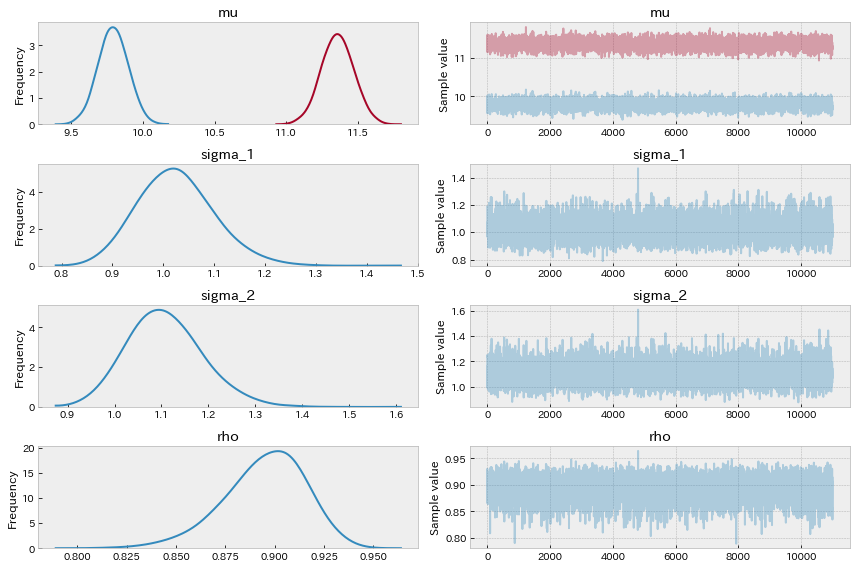

In [63]:
pm.traceplot(trace)

In [64]:
ans = sns.load_dataset('anscombe')

In [65]:
x_3 = ans[ans.dataset == "III"]['x'].values
y_3 = ans[ans.dataset == "III"]['y'].values

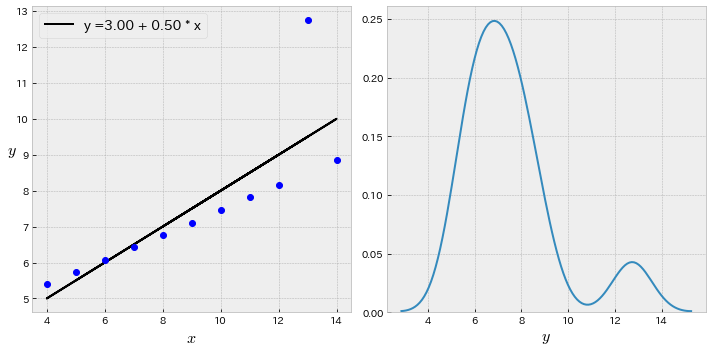

In [66]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
plt.plot(x_3, (alpha_c + beta_c* x_3), 'k', label='y ={:.2f} + {:.2f} * x'.format(alpha_c, beta_c))
plt.plot(x_3, y_3, 'bo')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=0, fontsize=14)
plt.subplot(1,2,2)
sns.kdeplot(y_3);
plt.xlabel('$y$', fontsize=16)
plt.tight_layout()

### コード4.18

In [68]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    mu = alpha + beta * x_3
    nu = pm.Deterministic('nu', pm.Exponential('nu_', 1/29) + 1)
    
    y_pred = pm.StudentT('y_pred', mu=mu, sd=epsilon, nu=nu, observed=y_3)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(2000, step, start, njobs=1, chains=1)

logp = -164.76, ||grad|| = 156.44: 100%|██████████| 176/176 [00:00<00:00, 1313.39it/s]      
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [nu_]
INFO:pymc3:>Metropolis: [nu_]
>Metropolis: [epsilon]
INFO:pymc3:>Metropolis: [epsilon]
>Metropolis: [beta]
INFO:pymc3:>Metropolis: [beta]
>Metropolis: [alpha]
INFO:pymc3:>Metropolis: [alpha]
100%|██████████| 2500/2500 [00:01<00:00, 1657.92it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks


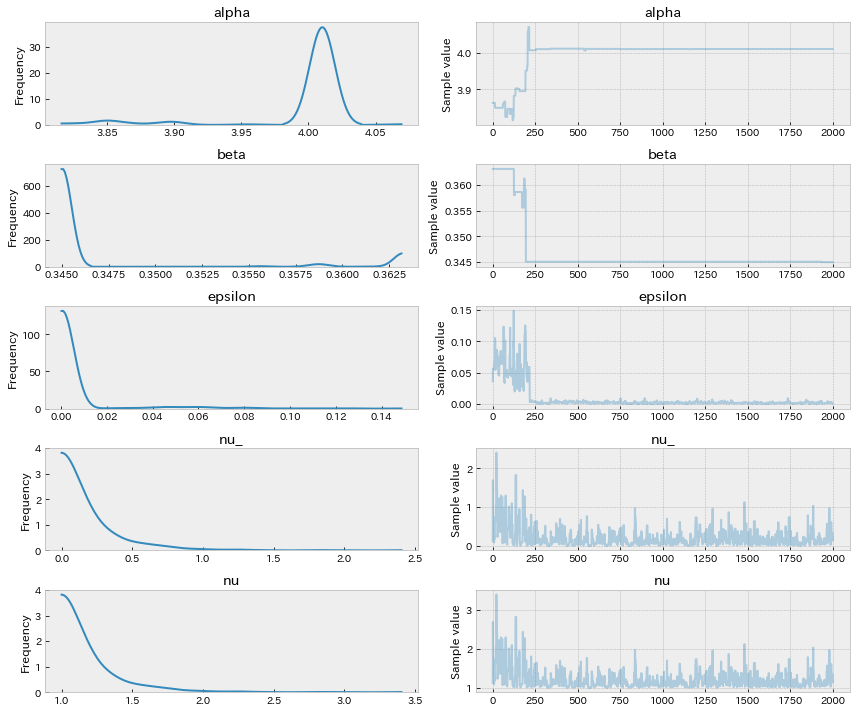

In [70]:
pm.traceplot(trace);

In [73]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,3.995505,0.043937,0.004346,3.849809,4.010530
beta,0.346659,0.004914,0.000487,0.345066,0.363151
epsilon,0.008581,0.019987,0.001849,0.000414,0.059105
nu_,0.207693,0.254406,0.015590,0.000105,0.712569
nu,1.207693,0.254406,0.015590,1.000105,1.712569


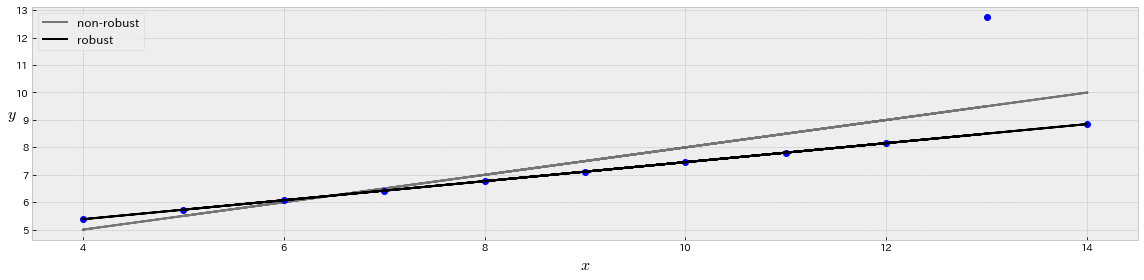

In [74]:
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]

plt.plot(x_3, (alpha_c + beta_c * x_3), 'k', label='non-robust', alpha=0.5)
plt.plot(x_3, y_3, 'bo')
alpha_m = trace['alpha'].mean()
beta_m = trace['beta'].mean()
plt.plot(x_3, alpha_m + beta_m * x_3, c='k', label='robust')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=2, fontsize=12)
plt.tight_layout()

100%|██████████| 200/200 [00:00<00:00, 214.39it/s]
/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'co

/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


Text(0.5,0,'$y$')

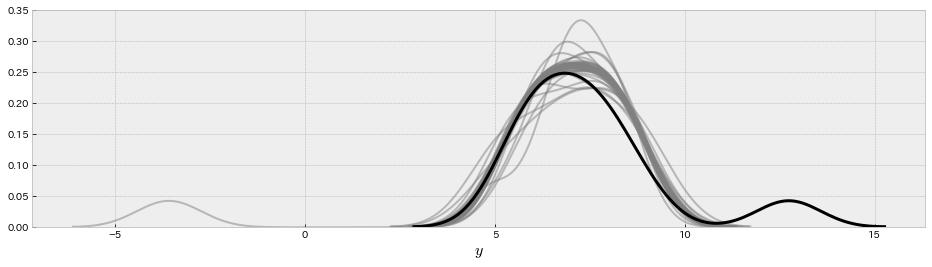

In [78]:
ppc = pm.sample_ppc(trace, samples=200, model=model, random_seed=2)

for y_tilde in ppc['y_pred']:
    sns.kdeplot(y_tilde, alpha=0.5, c='gray')

sns.kdeplot(y_3, linewidth=3, color='k')
plt.xlabel('$y$', fontsize=16)

In [79]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m  + eps_real

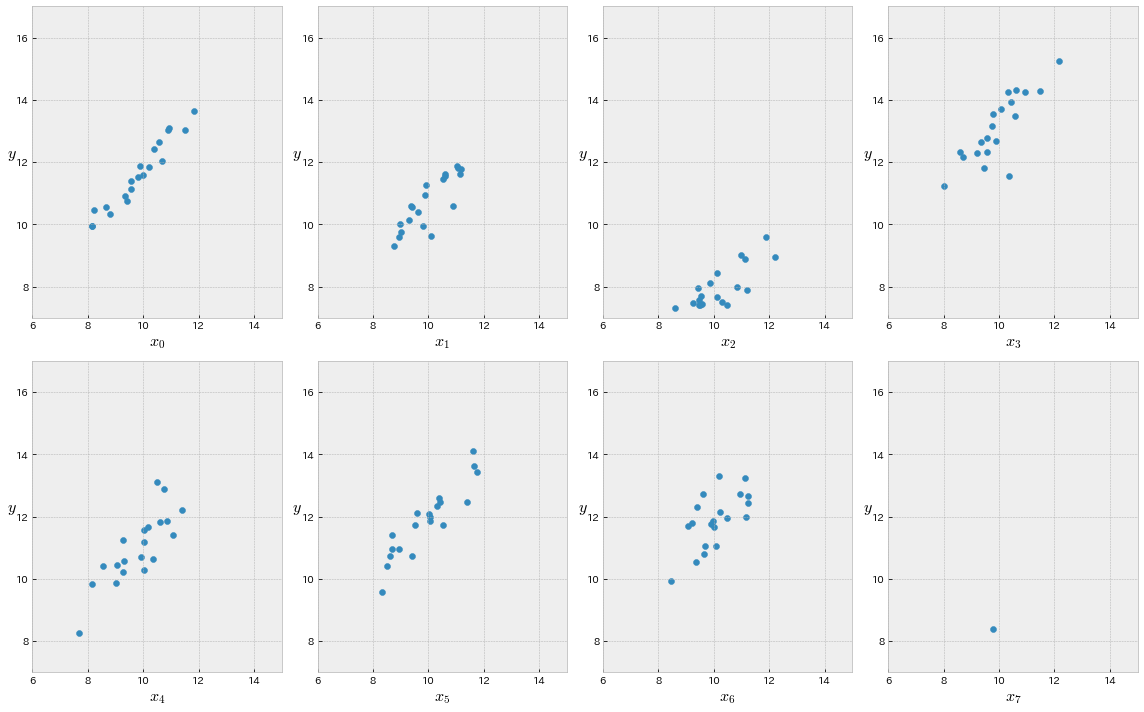

In [81]:
plt.figure(figsize=(16,10))
j, k = 0, N
for i in range(M):
    plt.subplot(2,4,i+1)
    plt.scatter(x_m[j:k], y_m[j:k])
    plt.xlabel('$x_{}$'.format(i), fontsize=16)
    plt.ylabel('$y$', fontsize=16, rotation=0)
    plt.xlim(6, 15)
    plt.ylim(7, 17)
    j += N
    k += N
plt.tight_layout()

In [82]:
x_centerd = x_m - x_m.mean()

In [87]:
with pm.Model() as model:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10, shape=M)
    beta = pm.Normal('beta', mu=0, sd=10, shape=M)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Exponential('nu', 1/30)
    y_pred = pm.StudentT(
        'y_pred', 
        mu=alpha_tmp[idx] + beta[idx] * x_centerd,
        sd=epsilon, nu=nu, observed=y_m
    )
    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_m.mean())
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(2000, step, start, njobs=1, chains=1)

logp = -161.03, ||grad|| = 0.18761: 100%|██████████| 66/66 [00:00<00:00, 1405.84it/s]  
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [nu]
INFO:pymc3:>Metropolis: [nu]
>Metropolis: [epsilon]
INFO:pymc3:>Metropolis: [epsilon]
>Metropolis: [beta]
INFO:pymc3:>Metropolis: [beta]
>Metropolis: [alpha_tmp]
INFO:pymc3:>Metropolis: [alpha_tmp]
100%|██████████| 2500/2500 [00:01<00:00, 1669.69it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks


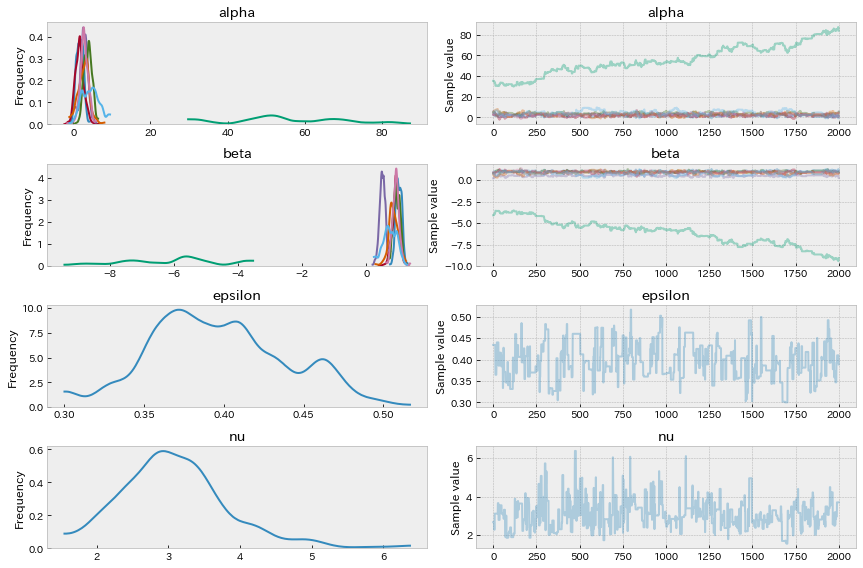

In [89]:
varnames = ['alpha', 'beta', 'epsilon', 'nu']
pm.traceplot(trace, varnames);

In [91]:
x_centered = x_m - x_m.mean()

In [93]:
with pm.Model() as model:
    alpha_tmp_mu = pm.Normal('alpha_tmp_mu', mu=0, sd=10)
    alpha_tmp_sd = pm.HalfNormal('alpha_tmp_sd', 10)
    beta_mu = pm.Normal('beta_mu', mu=0, sd=10)
    beta_sd = pm.HalfNormal('beta_sd', sd=10)
    
    alpha_tmp = pm.Normal('alpha_tmp', mu=alpha_tmp_mu, sd=alpha_tmp_sd, shape=M)
    beta = pm.Normal('beta', mu=beta_mu, sd=beta_sd, shape=M)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Exponential('nu', 1/30)
    
    y_pred = pm.StudentT(
        'y_pred', 
        mu=alpha_tmp[idx] + beta[idx] * x_centered,
        sd=epsilon, nu=nu, observed=y_m
    )
    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_m.mean())
    alpha_mu = pm.Deterministic('alpha_mu', alpha_tmp_mu - beta_mu * x_m.mean())
    alpha_sd = pm.Deterministic('alpha_sd', alpha_tmp_sd - beta_mu * x_m.mean())
    
    trace = pm.sample(1000, njobs=1, chains=1)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [nu, epsilon, beta, alpha_tmp, beta_sd, beta_mu, alpha_tmp_sd, alpha_tmp_mu]
INFO:pymc3:NUTS: [nu, epsilon, beta, alpha_tmp, beta_sd, beta_mu, alpha_tmp_sd, alpha_tmp_mu]
100%|██████████| 1500/1500 [00:07<00:00, 191.10it/s]
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks


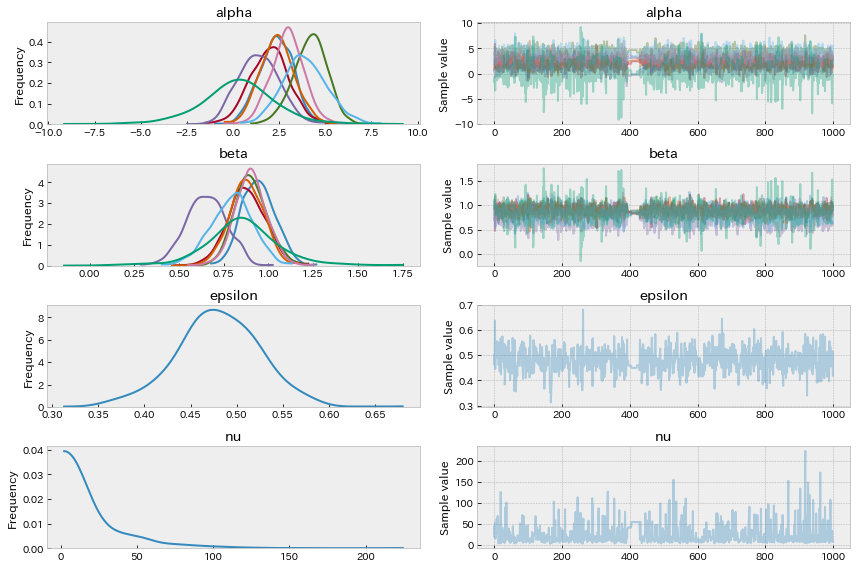

In [94]:
varnames=['alpha', 'beta', 'epsilon', 'nu']
pm.traceplot(trace, varnames);

In [95]:
pm.summary(trace, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,2.325833,0.896258,0.031594,0.631598,4.095758
alpha__1,1.969706,1.061024,0.034400,-0.084471,4.069655
alpha__2,1.385045,1.095859,0.050528,-0.744108,3.359948
alpha__3,4.184313,0.910962,0.030031,2.176909,5.690800
alpha__4,2.394276,0.931921,0.028058,0.664733,4.209796
alpha__5,2.940693,0.887349,0.027409,1.283802,4.709939
alpha__6,3.885387,1.192302,0.040878,1.489097,6.143887
alpha__7,0.242916,2.115233,0.066379,-3.950855,4.656318
beta__0,0.943434,0.091222,0.003301,0.788460,1.133822
beta__1,0.877328,0.105355,0.003447,0.669272,1.079587


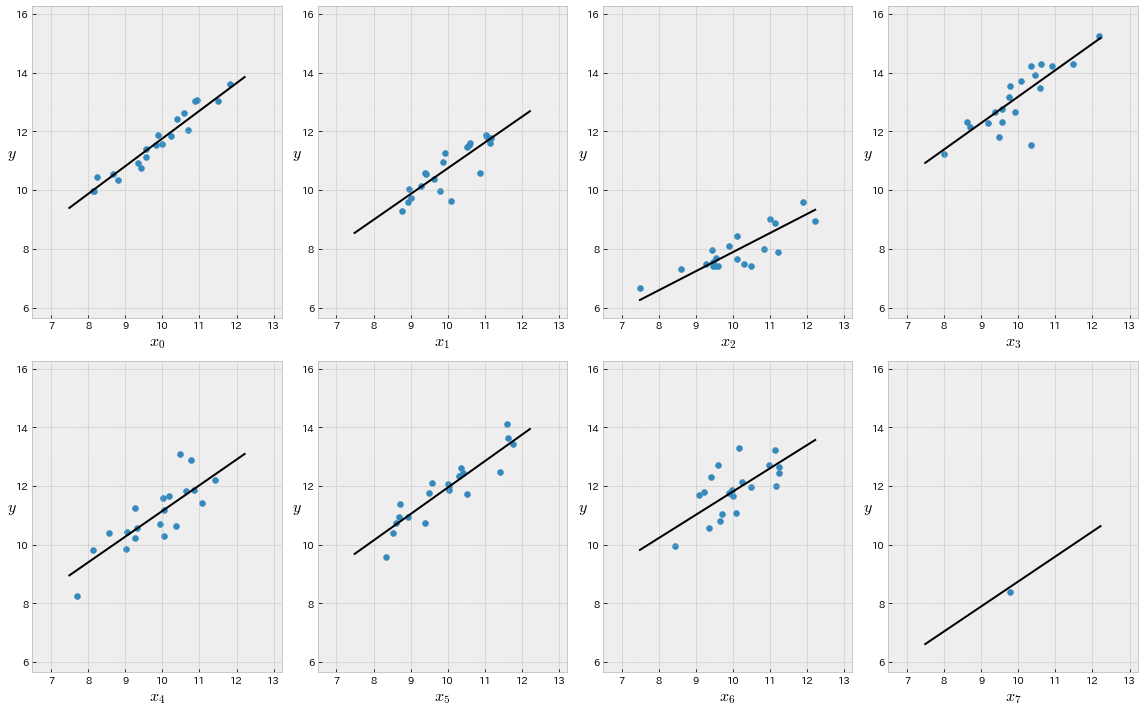

In [98]:
plt.figure(figsize=(16,10))
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    plt.subplot(2,4,i+1)
    plt.scatter(x_m[j:k], y_m[j:k])
    plt.xlabel('$x_{}$'.format(i), fontsize=16)
    plt.ylabel('$y$', fontsize=16, rotation=0)
    alfa_m = trace['alpha'][:,i].mean()
    beta_m = trace['beta'][:,i].mean()
    plt.plot(x_range, alfa_m + beta_m * x_range, c='k', label='y = {:.2f} + {:.2f} * x'.format(alfa_m, beta_m))
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N
plt.tight_layout()

Text(0,0.5,'$y$')

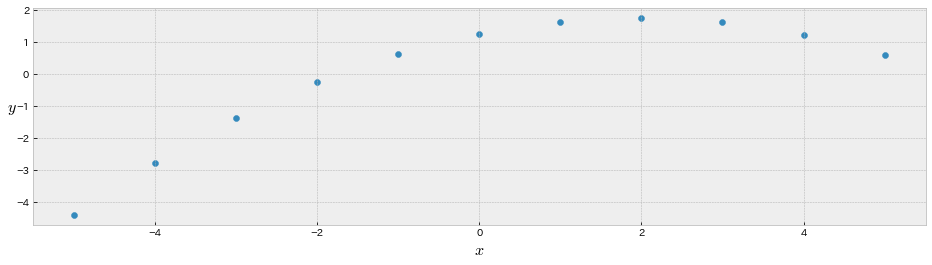

In [99]:
x_2 = ans[ans.dataset == 'II']['x'].values
y_2 = ans[ans.dataset == 'II']['y'].values
x_2 = x_2 - x_2.mean()
y_2 = y_2 - y_2.mean()

plt.scatter(x_2, y_2)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)

In [100]:
with pm.Model() as model_poly:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta1 = pm.Normal('beta1', mu=0, sd=1)
    beta2 = pm.Normal('beta2', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + beta1 * x_2 + beta2 * x_2**2
    
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y_2)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_poly = pm.sample(2000, step=step, start=start)

logp = 49.209, ||grad|| = 409.18: 100%|██████████| 85/85 [00:00<00:00, 1666.76it/s]           
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, beta2, beta1, alpha]
INFO:pymc3:NUTS: [epsilon, beta2, beta1, alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:03<00:00, 1468.93draws/s]


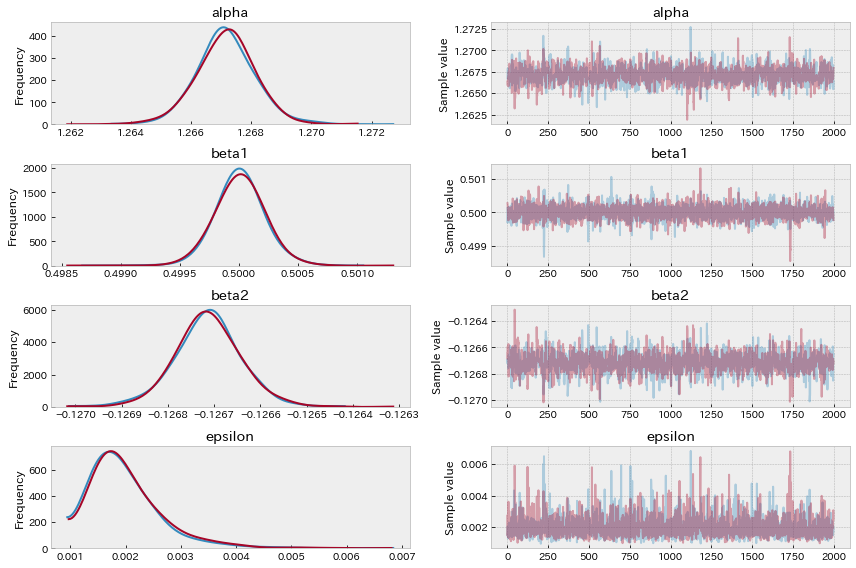

In [101]:
pm.traceplot(trace_poly);

In [103]:
N = 100
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)

X = np.array([np.random.normal(i, j, N) for i,j in zip([10, 2], [1, 1.5])])
X_mean = X.mean(axis=1, keepdims=True)
X_centered = X - X_mean
y = alpha_real + np.dot(beta_real, X) + eps_real

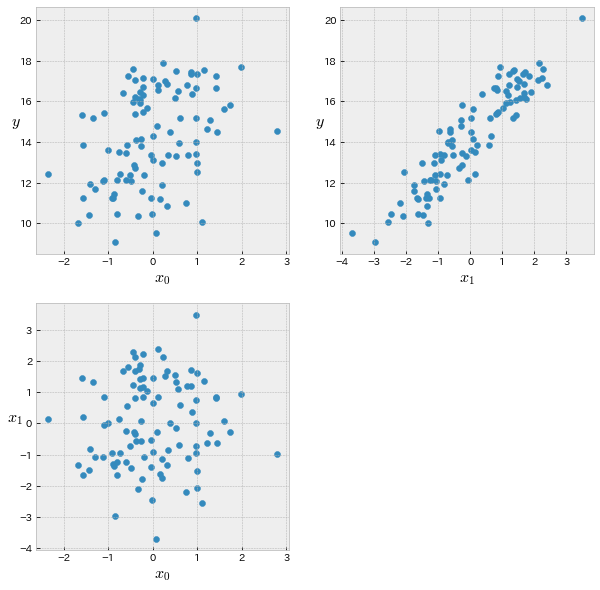

In [108]:
def scatter_plot(x, y):
    plt.figure(figsize=(10, 10))
    for idx, x_i in enumerate(x):
        plt.subplot(2, 2, idx+1)
        plt.scatter(x_i, y)
        plt.xlabel('$x_{}$'.format(idx), fontsize=16)
        plt.ylabel('$y$', rotation=0, fontsize=16)

    plt.subplot(2, 2, idx+2)
    plt.scatter(x[0], x[1])
    plt.xlabel('$x_{}$'.format(idx-1), fontsize=16)
    plt.ylabel('$x_{}$'.format(idx), rotation=0, fontsize=16)

scatter_plot(X_centered, y)

In [111]:
with pm.Model() as model_mlr:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=2)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha_tmp + pm.math.dot(beta, X_centered)

    alpha = pm.Deterministic('alpha', alpha_tmp - pm.math.dot(beta, X_mean)) 

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_mlr = pm.sample(5000, step=step, start=start)

logp = -86.978, ||grad|| = 5.3018: 100%|██████████| 37/37 [00:00<00:00, 1187.80it/s]   
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, beta, alpha_tmp]
INFO:pymc3:NUTS: [epsilon, beta, alpha_tmp]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:05<00:00, 1943.44draws/s]


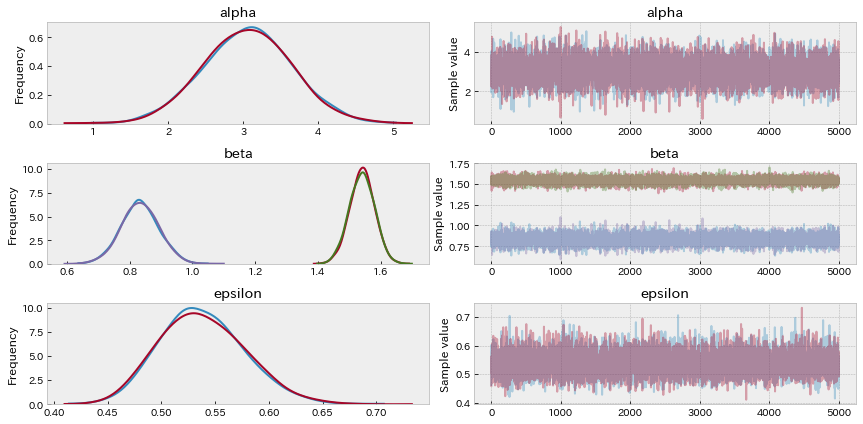

In [112]:
varnames = ['alpha', 'beta','epsilon']
pm.traceplot(trace_mlr, varnames);

In [113]:
pm.summary(trace_mlr, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,3.059184,0.588566,0.004280,1.932569,4.242596,15768.092617,0.999941
beta__0,0.833493,0.059747,0.000445,0.721215,0.956180,15378.595543,0.999978
beta__1,1.540809,0.039237,0.000291,1.463285,1.617374,13616.581568,1.000030
epsilon,0.538434,0.039426,0.000367,0.465270,0.616545,13912.343080,0.999910


In [114]:
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=1)
#x_2 = x_1 + np.random.normal(size=N, scale=0.01)  
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2))

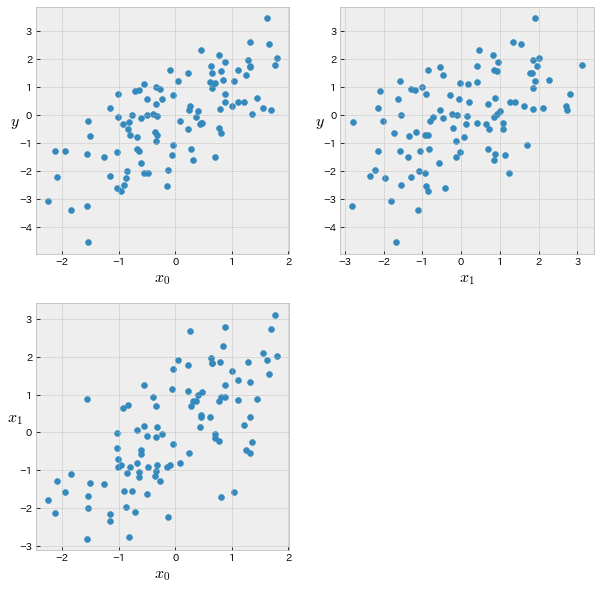

In [115]:
scatter_plot(X, y)

In [116]:
with pm.Model() as model_red:
    alpha = pm.Normal('alpha', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + pm.math.dot(beta, X)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
 
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_red = pm.sample(5000, step=step, start=start)

logp = -159.63, ||grad|| = 0.12915: 100%|██████████| 15/15 [00:00<00:00, 1716.87it/s]  
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, beta, alpha]
INFO:pymc3:NUTS: [epsilon, beta, alpha]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:07<00:00, 1535.21draws/s]


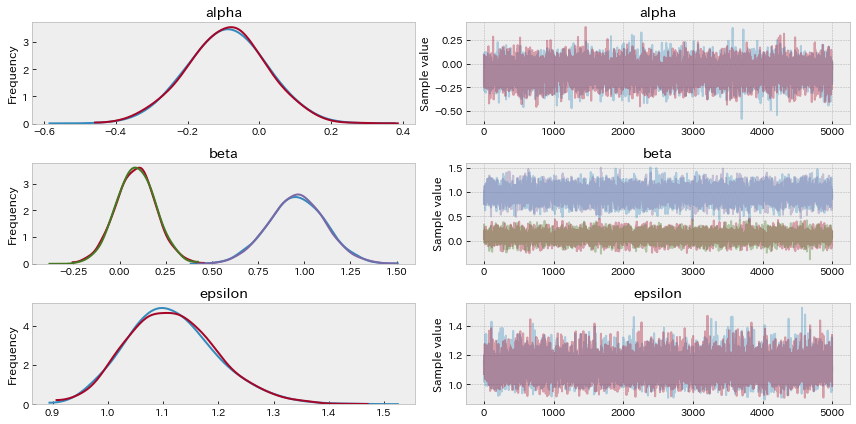

In [117]:
pm.traceplot(trace_red);

In [119]:
pm.summary(trace_red)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-0.090180,0.110699,0.001082,-0.308147,0.123969,12056.018090,0.999916
beta__0,0.959572,0.152112,0.002111,0.649671,1.248927,4557.375688,0.999902
beta__1,0.088337,0.107211,0.001550,-0.116985,0.306412,4265.410661,0.999931
epsilon,1.116982,0.081921,0.000746,0.962319,1.279942,12065.214613,0.999939


Text(0,0.5,'$\\beta_2$')

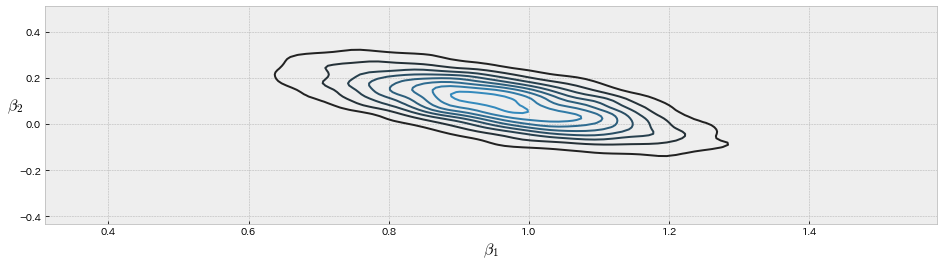

In [120]:
sns.kdeplot(trace_red['beta'][:,0], trace_red['beta'][:,1])
plt.xlabel(r'$\beta_1$', fontsize=16)
plt.ylabel(r'$\beta_2$', fontsize=16, rotation=0)

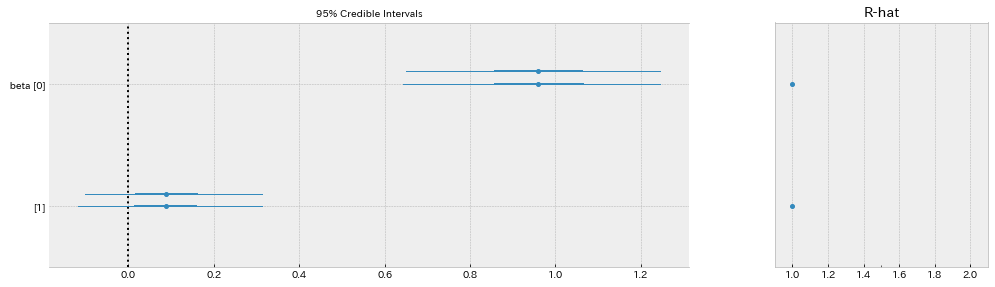

In [122]:
pm.forestplot(trace_red, varnames=['beta']);

In [123]:
N = 100
r = 0.8
x_0 = np.random.normal(size=N)
x_1 = np.random.normal(loc=x_0 * r, scale=(1 - r ** 2) ** 0.5)
y = np.random.normal(loc=x_0 - x_1)
X = np.vstack((x_0, x_1))

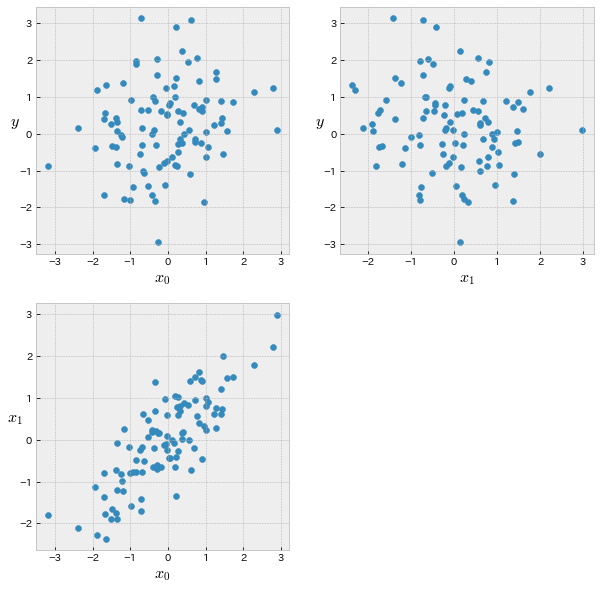

In [124]:
scatter_plot(X, y);

In [125]:
with pm.Model() as model_ma:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + pm.math.dot(beta, X)

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_ma = pm.sample(5000, step=step, start=start)

logp = -148.15, ||grad|| = 0.0084712: 100%|██████████| 13/13 [00:00<00:00, 1289.55it/s]  
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, beta, alpha]
INFO:pymc3:NUTS: [epsilon, beta, alpha]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:07<00:00, 1400.53draws/s]


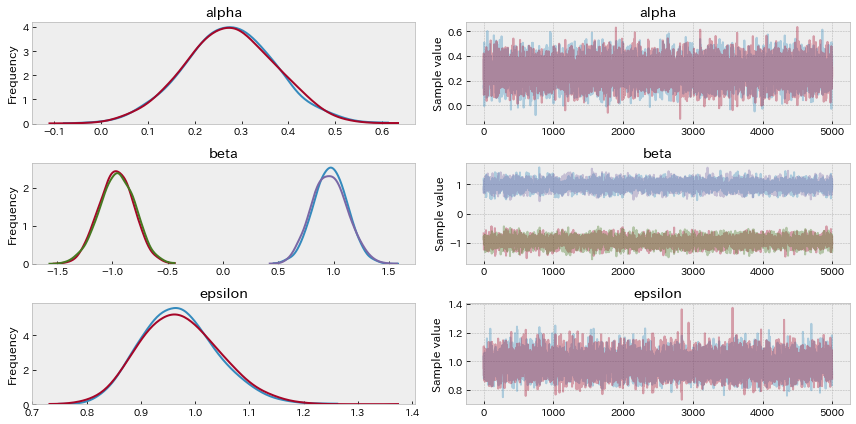

In [126]:
pm.traceplot(trace_ma);

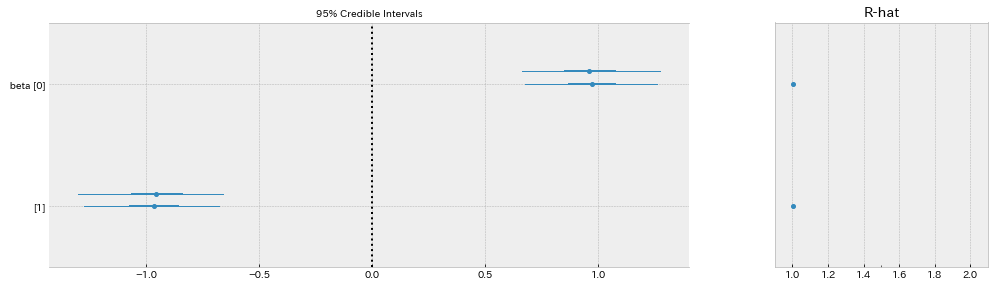

In [127]:
pm.forestplot(trace_ma, varnames=['beta']);